In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import find_peaks
from scipy import integrate
from scipy.stats import shapiro, f_oneway, ttest_ind
from annotator_amide_abs import annotator
from scipy.ndimage import gaussian_filter1d
%matplotlib widget

In [2]:
wave_no = pd.read_csv('../mdi_optimization/cleaned_csvs/wave_no.csv')

kgy0 = pd.read_csv('../mdi_optimization/cleaned_csvs/48_scans.csv').drop(columns=['wave_no'])
kgy5 = pd.read_csv('../irradiated_analysis/5kgy/5kgy_sn48.csv')
kgy10 = pd.read_csv('../irradiated_analysis/10kgy/10kgy_sn48.csv')

for df in [kgy0, kgy5, kgy10]:
    df['average'] = df.iloc[:,:].mean(axis=1)

Broad Amide Region Area Visualization

C:\Users\barbie\AppData\Local\Temp\ipykernel_5460\663727768.py:23: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  if 1180 <= float(wave_no.iloc[peak,:]) <= 1780:


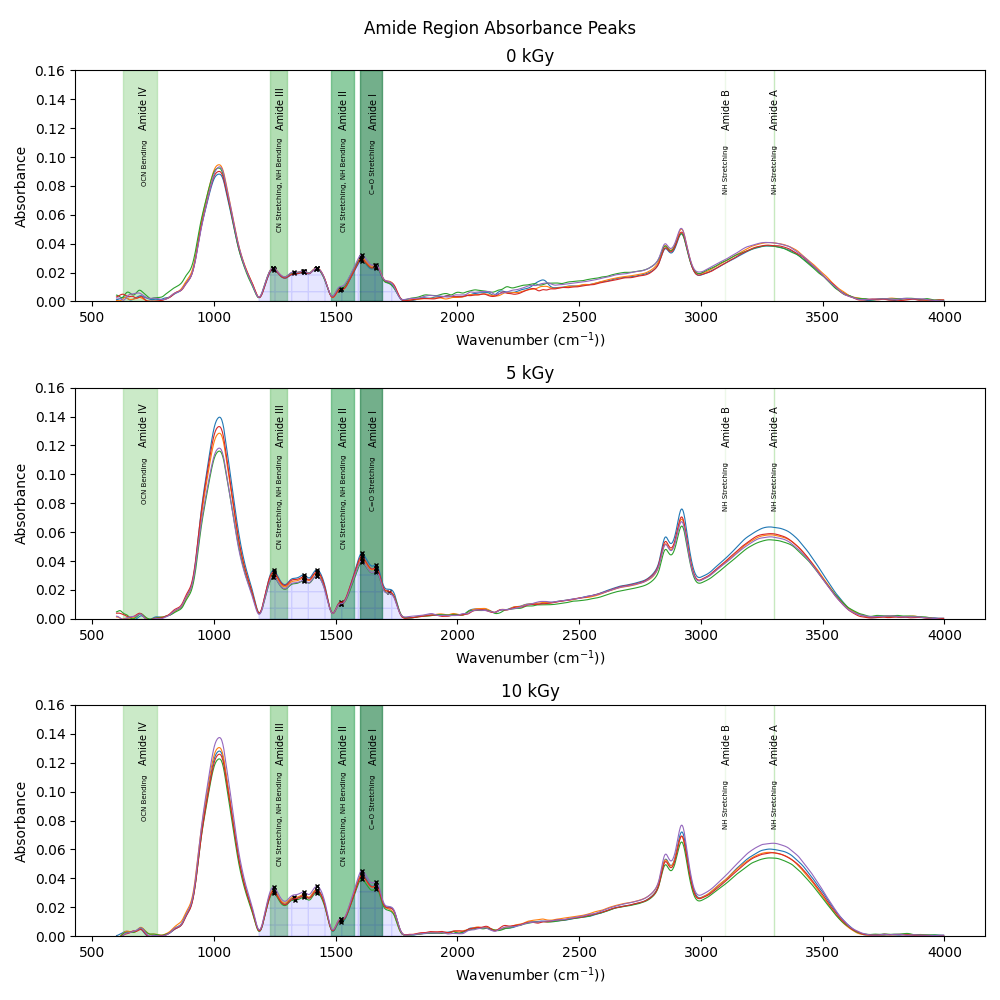

In [3]:
plt.close('all')
fig, axes = plt.subplots(3,1, figsize=(10,10))
fig.suptitle('Amide Region Absorbance Peaks')

for axis, group, group_name in zip(axes, [kgy0, kgy5, kgy10], ['0 kGy', '5 kGy', '10 kGy']):
    annotator(axis)

    for samp in group.columns[0:5]:
        spec = group[samp]

        sigma=5
        spec = gaussian_filter1d(spec, sigma)

        peaks, params = find_peaks(spec, distance=18)

        axis.plot(wave_no, spec, linewidth=0.8)
        axis.fill_between(wave_no['wave_no'].iloc[1080:1366], spec[1080:1366], 0, color='blue', alpha=0.02, hatch='+') # Analysis region
        axis.set(title=f"{group_name}",
                 xlabel='Wavenumber (cm$^{-1}$))',
                 ylabel='Absorbance')

        for peak in peaks:
            if 1180 <= float(wave_no.iloc[peak,:]) <= 1780:
                axis.plot(wave_no.iloc[peak,:], spec[peak], 'x', markersize=3.5, markeredgewidth=1, color='black')

fig.tight_layout()

Broad Amide Region Area Computation

In [4]:
wave_amide = wave_no['wave_no'].iloc[1080:1366]
amide_area_df = pd.DataFrame()

for df, group_name in zip([kgy0, kgy5, kgy10], ['0kGy_amide_area', '5kGy_amide_area', '10kGy_amide_area']):
    area_group = []
    for samp in df.columns[0:6]:
        spec_amide = df[samp][1080:1366]
        amide_area = integrate.simpson(np.flip(spec_amide), x=np.flip(wave_amide))
        area_group.append(amide_area)

    amide_area_df[group_name] = list(area_group)

Test for Normality

In [5]:
kgy_amide_area = [amide_area_df[col] for col in amide_area_df.columns]

In [6]:
for group, area in zip(['0kGy_amide_area', '5 kGy_amide_area', '10 kGy_amide_area'], kgy_amide_area):
    alpha=0.05

    s_stat, s_p = shapiro(area, nan_policy='omit')

    normal = True
    if s_p < alpha: normal = False

    print(f'Scan No. {group} {normal=} {s_stat=} {s_p=} ')

Scan No. 0kGy_amide_area normal=True s_stat=0.953214225555281 s_p=0.766212664380058 
Scan No. 5 kGy_amide_area normal=True s_stat=0.9661111632530114 s_p=0.8653670837025791 
Scan No. 10 kGy_amide_area normal=True s_stat=0.9636905695784804 s_p=0.8476824020681082 


One-Way ANOVA

In [7]:
f_stat, f_p = f_oneway(*kgy_amide_area, nan_policy='omit')
sig_dif = False
if f_p < alpha: sig_dif = True

print(f'{sig_dif=} {f_stat=} {f_p=}')

sig_dif=True f_stat=40.11226331798301 f_p=9.55142730290285e-07


Pairwise Comparison (t-test)

In [9]:
print('5 v 10')
t_stat, t_p = ttest_ind(amide_area_df['5kGy_amide_area'], amide_area_df['10kGy_amide_area'])
sig_dif = False
if t_p < alpha: sig_dif = True
print(f'{sig_dif=} {t_stat=} {t_p=}')


print('\n0 v 5')
t_stat, t_p = ttest_ind(amide_area_df['0kGy_amide_area'], amide_area_df['5kGy_amide_area'])
sig_dif = False
if t_p < alpha: sig_dif = True
print(f'{sig_dif=} {t_stat=} {t_p=}')


print('\n0 v 10')
t_stat, t_p = ttest_ind(amide_area_df['0kGy_amide_area'], amide_area_df['10kGy_amide_area'])
sig_dif = False
if t_p < alpha: sig_dif = True
print(f'{sig_dif=} {t_stat=} {t_p=}')

5 v 10
sig_dif=False t_stat=-0.49445902050968293 t_p=0.6316636754474607

0 v 5
sig_dif=True t_stat=-7.955411079073046 t_p=1.2365325955729616e-05

0 v 10
sig_dif=True t_stat=-8.795652859611677 t_p=5.084750707950433e-06
